In [1]:
#%pip install opencv-python
# %pip install GPUtil
# %pip install numba
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch, DataLoader
from torch_geometric.nn import global_add_pool, GCNConv, GlobalAttention, GraphConv, SAGEConv, TopKPooling
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch

from torch.utils.data import Dataset
from torchvision.transforms import transforms
import h5py
import torch
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import random

from matplotlib import pyplot as plt

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


"""
To extract nonzero pixels, I consider those pixels with nonzero values in at least one of the three channels
I also normalized every channel based on the mean and std value of that channel
"""
class Quark_Gluon_Dataset_v2(Dataset):
    def __init__(self, train_data_size):
        with h5py.File('data/quark-gluon_data-set_n139306.hdf5', 'r') as f:
            print(f.keys())
            self.X_jets_data = f['X_jets'][:train_data_size]
            self.y_data = f['y'][:train_data_size]
            # transforms.Compose([transforms.Resize(256)])
            self.transform = transforms.Compose([transforms.ToTensor()])
            self.graphs, self.labels = self.process_data()

        f.close()
        del f

    def create_graph_data_v2(self, x_jet, x_jet_normalized, y):
        none_zero_point_cloud = []
        graph = []
        for i in range(len(x_jet[0])):
            for j in range(len(x_jet[0][i])):
                graph.append([i, j, x_jet_normalized[i][j][0], x_jet_normalized[i][j][1], x_jet_normalized[i][j][2]])
                if x_jet[0][i][j] != 0 or x_jet[1][i][j] != 0 or x_jet[2][i][j] != 0:
                    none_zero_point_cloud.append(
                        [i, j, x_jet_normalized[i][j][0], x_jet_normalized[i][j][1], x_jet_normalized[i][j][2]])

        # Compute the k-NN graph using the point cloud
        xy_coordinates = [x[:2] for x in none_zero_point_cloud]
        # nbrs = NearestNeighbors(radius=3, algorithm='ball_tree').fit(xy_coordinates)
        # distances, indices = nbrs.radius_neighbors(xy_coordinates)
        nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(xy_coordinates)
        distances, indices = nbrs.kneighbors(xy_coordinates)
        # nbrs = NearestNeighbors(radius=5, algorithm='ball_tree').fit(none_zero_point_cloud)
        # distances, indices = nbrs.radius_neighbors(none_zero_point_cloud)
        # Convert the k-NN graph to a NetworkX graph

        edges = []
        for i, node in enumerate(indices):
            for j, neigbour in enumerate(node):
                i_id = none_zero_point_cloud[i][0] * 125 + none_zero_point_cloud[i][1]
                j_id = none_zero_point_cloud[j][0] * 125 + none_zero_point_cloud[j][1]
                if i_id != j_id:
                    edges.append([i_id, j_id, distances[i][j]])

        x = torch.tensor(graph, dtype=torch.float)
        edge_index = torch.tensor([x[:2] for x in edges], dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor([x[2] for x in edges], dtype=torch.float)
        y = torch.tensor(int(y), dtype=torch.long)
        # data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data = Data(x=x, edge_index=edge_index, y=y)
        return data, edges


    def process_data(self):
        graphs = []
        labels = []
        counter = 0
        for x_jet, y in zip(self.X_jets_data, self.y_data):
            counter += 1
            mean = np.mean(x_jet, axis=(0, 1))
            std = np.std(x_jet, axis=(0, 1))
            x_jet_normalized = (x_jet - mean) / std
            x_jet_tensor = self.transform(x_jet)
            x_jet_data, edges = self.create_graph_data_v2(x_jet_tensor, x_jet_normalized, y)
            y = torch.tensor(int(y), dtype=torch.long)

            graphs.append(x_jet_data)
            labels.append(y)

        return graphs, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        return self.graphs[index], self.labels[index]




class Quark_Gluon_Dataset(Dataset):
    def __init__(self, train_size):
        with h5py.File('data/quark-gluon_data-set_n139306.hdf5', 'r') as f:
            print(f.keys())
            self.X_jets_data = f['X_jets'][:train_size]
            self.y_data = f['y'][:train_size]
            # transforms.Compose([transforms.Resize(256)])
            self.transform = transforms.Compose([transforms.ToTensor()])
            self.graph_data = self.convert_2_point_cloud()


            # Read the data from the dataset into a numpy array
        f.close()
        del f

    def convert_2_point_cloud(self):
        res_train = []
        res_eval = []
        counter = 0
        for x_jet, y in zip(self.X_jets_data, self.y_data):
            counter+=1

            mean = np.mean(x_jet, axis=(0, 1))
            std = np.std(x_jet, axis=(0, 1))
            x_jet = (x_jet - mean) / std
            # x_jet = 2 * (x_jet.transpose((2, 1, 0)) / 255) - 1
            # plt.imshow(x_jet.transpose((2,1,0)))
            # plt.imshow(x_jet)
            # plt.show()
            x_jet = self.transform(x_jet)

            torch.permute(x_jet, (2, 1, 0))
            img_gray = cv2.cvtColor(x_jet.permute(2,1,0).numpy(), cv2.COLOR_RGB2GRAY)
            img_gray = x_jet.numpy().sum(axis=0)
            max_channel = np.max(x_jet.permute(2,1,0).numpy(), axis=2, keepdims=True)  # Compute the max value for each pixel across the 3 channels
            img_gray = max_channel.squeeze()

            # Extract the coordinates of non-zero pixels
            y_coords, x_coords = np.nonzero(img_gray)
            np.column_stack((x_coords, y_coords, img_gray[y_coords, x_coords]))
            np.column_stack((x_coords, y_coords, 10*x_jet[0][y_coords, x_coords], 10*x_jet[1][y_coords, x_coords],
                             10*x_jet[2][y_coords, x_coords]))
            # Create a point cloud dataset
            point_cloud = np.column_stack((x_coords, y_coords, np.zeros_like(x_coords)))
            point_cloud = np.column_stack((x_coords, y_coords))
            point_cloud = np.column_stack((x_coords, y_coords, x_jet[0][y_coords, x_coords], x_jet[1][y_coords, x_coords],
                             x_jet[2][y_coords, x_coords]))

            k = 10

            # Compute the k-NN graph using the point cloud
            nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
            distances, indices = nbrs.kneighbors(point_cloud)
            # Convert the k-NN graph to a NetworkX graph
            graph = nx.Graph()
            for i in range(len(point_cloud)):
                for j in range(1, k):
                    graph.add_edge(i, indices[i][j], weight=distances[i][j])

            # Add the feature vectors as node attributes
            for i in range(len(point_cloud)):
                graph.nodes[i]['feature'] = point_cloud[i]

            x = torch.tensor(point_cloud, dtype=torch.float)
            edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges], dtype=torch.float)
            y = torch.tensor(int(y), dtype=torch.long)
            #data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            data = Data(x=x, edge_index=edge_index, y=y)

            res_train.append(data)
        return res_train


    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, indx):
        return self.graph_data[indx]






In [3]:
class Quark_Gluon_Dataset_v3(Dataset):
    def __init__(self, start,train_data_size):
        with h5py.File('data/quark-gluon_data-set_n139306.hdf5', 'r') as f:
            print(f.keys())

            self.X_jets_data = f['X_jets'][start:train_data_size]
            self.y_data = f['y'][start:train_data_size]
            # transforms.Compose([transforms.Resize(256)])
            self.transform = transforms.Compose([transforms.ToTensor()])
            self.graphs, self.labels = self.process_data()

        f.close()
        del f

    def create_graph_data_v2(self, x_jet, x_jet_normalized, y):
        none_zero_point_cloud = []
        graph = []
        for i in range(len(x_jet[0])):
            for j in range(len(x_jet[0][i])):
                if x_jet[0][i][j] != 0 or x_jet[1][i][j] != 0 or x_jet[2][i][j] != 0:
                    none_zero_point_cloud.append(
                        [i, j, x_jet_normalized[i][j][0], x_jet_normalized[i][j][1], x_jet_normalized[i][j][2]])

        # Compute the k-NN graph using the point cloud
        xy_coordinates = [x[:2] for x in none_zero_point_cloud]
        # nbrs = NearestNeighbors(radius=5, algorithm='ball_tree').fit(xy_coordinates)
        # distances, indices = nbrs.radius_neighbors(xy_coordinates)
        nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(xy_coordinates)
        distances, indices = nbrs.kneighbors(xy_coordinates)
        
        # Convert the k-NN graph to a NetworkX graph

        edges = []
        for i, node in enumerate(indices):
            for j, neigbour in enumerate(node):
                if i != j:
                    edges.append([i, j, distances[i][j]])

        x = torch.tensor(none_zero_point_cloud, dtype=torch.float)
        edge_index = torch.tensor([x[:2] for x in edges], dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor([x[2] for x in edges], dtype=torch.float)
        y = torch.tensor(int(y), dtype=torch.long)
        # data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data = Data(x=x, edge_index=edge_index, y=y)
        return data, edges


    def process_data(self):
        graphs = []
        labels = []
        counter = 0
        for x_jet, y in zip(self.X_jets_data, self.y_data):
            counter += 1
            mean = np.mean(x_jet, axis=(0, 1))
            std = np.std(x_jet, axis=(0, 1))
            x_jet_normalized = (x_jet - mean) / std
            x_jet_tensor = self.transform(x_jet)
            x_jet_data, edges = self.create_graph_data_v2(x_jet_tensor, x_jet_normalized, y)
            y = torch.tensor(int(y), dtype=torch.long)

            graphs.append(x_jet_data)
            labels.append(y)

        return graphs, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        return self.graphs[index], self.labels[index]


In [4]:
class GCN4(torch.nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(GCN4, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = SAGEConv(num_features, hidden_size)
        self.bn1 = torch.nn.BatchNorm1d(hidden_size)
        self.pool1 = TopKPooling(hidden_size, ratio=0.8)
        self.conv2 = SAGEConv(hidden_size, hidden_size)
        self.bn2 = torch.nn.BatchNorm1d(hidden_size)
        self.pool2 = TopKPooling(hidden_size, ratio=0.8)
        self.conv3 = SAGEConv(hidden_size, hidden_size)
        self.bn3 = torch.nn.BatchNorm1d(hidden_size)
        self.pool3 = TopKPooling(hidden_size, ratio=0.8)
        # self.lin = nn.Linear(hidden_size, num_classes)
        self.classifier_hidden1 = nn.Linear(hidden_size, hidden_size // 2)
        self.classifier_bn1 = torch.nn.BatchNorm1d(hidden_size//2)
        self.classifier_hidden2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.classifier_bn2 = torch.nn.BatchNorm1d(hidden_size//4)
        self.classifier_output = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x, edge_index, batch):
        

        # 1. Obtain node embeddings
        x = self.bn1(self.conv1(x, edge_index))
        x = x.relu()
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x = self.bn2(self.conv2(x, edge_index))
        x = x.relu()
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x = self.bn3(self.conv3(x, edge_index))

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.relu(self.classifier_bn1(self.classifier_hidden1(x)))
        x = F.relu(self.classifier_bn2(self.classifier_hidden2(x)))
        x = self.classifier_output(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.lin(x)

        return x


In [5]:

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
    
    allocated = torch.cuda.memory_allocated()
    cached = torch.cuda.memory_cached()
    print(f"GPU memory allocated: {allocated/(1024**3):.2f} GB")

free_gpu_cache()

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/py

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


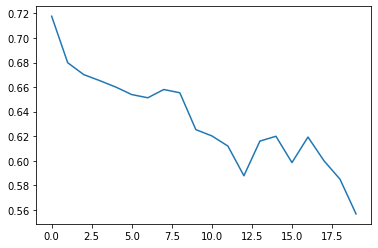

In [6]:

train_size = 1000
start = 0
# device = ('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
q_g_data   = Quark_Gluon_Dataset_v3(start,train_size)

# q_g_data   = Quark_Gluon_Dataset(train_size)

#sample_graph, sample_y = q_g_data[0]
# batched_graph = Batch.from_data_list(q_g_data)
# Print some information about the graph
# print(nx.info(sample_graph))


# Define the hyperparameters
num_features = 5  # number of input features per node
hidden_size = 128  # number of hidden units
num_classes = 2  # number of output classes
learning_rate = 0.001
num_epochs = 20
loader = DataLoader(q_g_data, batch_size=32, shuffle=True)
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Create the GCN model and optimizer
model = GCN4(num_features, hidden_size, num_classes)
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_list = []
for epoch in range(num_epochs):
    batch_loss = 0
    counter = 0
    for graphs, _ in loader:
        x, edge_index, batch, labels = graphs.x, graphs.edge_index, graphs.batch, graphs.y
        counter+=1
        x = x.to(device)
        edge_index = edge_index.to(device)
        batch = batch.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = model(x, edge_index, batch)
        loss = F.cross_entropy(out, labels)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(batch_loss/counter)
    loss_list.append(batch_loss/counter)
    
plt.plot(loss_list)
plt.show()

print('after training')



In [7]:
model.eval()
model.to('cpu')


loader2 = DataLoader(q_g_data, batch_size=32, shuffle=False)

for graphs, _ in loader2:


    x, edge_index, batch, labels = graphs.x, graphs.edge_index, graphs.batch, graphs.y
    
    out = model(x, edge_index, batch)
    pred = out.argmax(dim=1)
    acc = (pred == labels).sum().item() / len(labels)
    print(f'Test accuracy: {acc:.4f}')

Test accuracy: 0.6562
Test accuracy: 0.7500
Test accuracy: 0.6562
Test accuracy: 0.7500
Test accuracy: 0.6562
Test accuracy: 0.7188
Test accuracy: 0.7812
Test accuracy: 0.6562
Test accuracy: 0.6562
Test accuracy: 0.8125
Test accuracy: 0.7812
Test accuracy: 0.8125
Test accuracy: 0.8125
